# Regressão Não Paramétrica (Nonparametric Regression)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

* Introdução
  * Regressão Paramétrica
  * Regressão Não Paramétrica
  * Regressão Semiparamétrica
* Regressão Polinomial 
* Medidas de Ajuste
* Regressões da Família Binomial
* *Step Functions* (Regressão com Funções Degrau/Escalonadas)
* *Splines Regression*
  * Splines Cúbicas com Vários Nós
* *Local Regression*
* *Generalized Additive Models* (GAMs - Modelos Aditivos Generalizados)
* *Exemplo GAM adicional: efeito do fumo durante a gestação no peso ao nascer*

### Referências

* [Introduction to Statistical Learning](https://www.statlearning.com/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Splines e funções base (Capítulo 7 do ISLR);
  * Modelos aditivos generalizados (GAMs);
  * Regressão local.
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman
  * Capítulo 7 do ESL;
  * Capítulo 8 do ESL.
* Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly Media, 2019.


### 1. Introdução

Nesta aula, exploraremos as técnicas de **regressão não paramétrica**, com foco em métodos que não impõem uma forma funcional específica para a relação entre as variáveis independentes e a variável dependente. Esse tipo de abordagem é particularmente útil em situações em que essa relação é **complexa ou desconhecida**.

Uma ***relação complexa*** refere-se a situações em que os efeitos das variáveis explicativas sobre a variável de interesse **não podem ser capturados adequadamente por funções lineares ou polinomiais de baixa ordem**. Isso pode ocorrer, por exemplo, quando há mudanças bruscas de inclinação, efeitos em diferentes escalas ou interações não lineares entre os regressores.

Nesse contexto, os modelos não paramétricos oferecem maior flexibilidade ao permitir que os dados “falem por si”, evitando a imposição de uma estrutura funcional incorreta que possa induzir a **viés de especificação**.

**Definições Fundamentais**

**Regressão Paramétrica**
Modelos que especificam completamente a forma funcional (global) da relação entre as variáveis, assumindo que os dados seguem uma distribuição parametrizada por um número finito de parâmetros.

- **Exemplos típicos**: Regressão Linear Clássica (OLS); modelos Logit e Probit; modelos ARIMA em séries temporais; regressões exponenciais e log-lineares.
- **Características**:  
  - Forma funcional totalmente especificada (ex.: linear, quadrática).  
  - Estimativa baseada em um número fixo de parâmetros.  
  - Mais eficientes quando bem especificados, mas sensíveis à má especificação da forma funcional.


**Regressão Não Paramétrica**
Modelos que **não impõem uma forma funcional específica** entre as variáveis. Em vez disso, permitem que os dados determinem a forma da relação, geralmente exigindo amostras maiores para obter estimativas confiáveis.

- **Exemplos típicos**: Regressão por Núcleo (Kernel Regression de Nadaraya-Watson); K-Vizinhos Mais Próximos (KNN); Árvores de Decisão, Random Forest, BART; Splines; LOESS.
- **Características**:  
  - Alta flexibilidade, capaz de capturar relações complexas e não lineares.  
  - Alta demanda por dados (problema da *curse of dimensionality*).  
  - Não especificam um número fixo de parâmetros.  
  - Resultados podem ser mais difíceis de interpretar.


**Regressão Semiparamétrica**
Modelos que combinam componentes paramétricos e não paramétricos. Em geral, assumem uma estrutura funcional para parte dos efeitos e deixam o restante livre, a ser estimado de forma não paramétrica.

- **Exemplos típicos**:  
  - Modelo de Cox na análise de sobrevivência.  
  - Double Machine Learning (DML), com uso de algoritmos de aprendizado de máquina para controle de covariáveis.  
  - Modelo de Regressão Parcialmente Linear:

    $$ y_i = X_i' \beta + g(Z_i) + \varepsilon_i $$

  - onde $y_i$ é a variável dependente, $X_i$ é um vetor de variáveis independentes, $\beta$ é um vetor de parâmetros a serem estimados, $g(Z_i)$ é uma função não-paramétrica das variáveis $Z_i$, e $\epsilon_i$ é o erro aleatório.

* ***Características:***
  * Oferecem equilíbrio entre estrutura e flexibilidade.
  * Menos dependentes da correta especificação da forma funcional.
  * Mais interpretáveis que modelos totalmente não paramétricos, e mais robustos que modelos totalmente paramétricos.


Minha ideia para essa aula é conduzir vocês da relação paramétrica que estamos acostumados, em direção à modelos com relação não paramétrica.

Vamos construir a aula sobre exemplos práticos, e depois discutir as definições.

**Carregando pacotes**

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from patsy import dmatrix
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.stats import norm
from pygam import LinearGAM, LogisticGAM, s, f
from sklearn.preprocessing import LabelEncoder

**Carregando Dados**

In [91]:
df = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Wage.csv', index_col=0)
df

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
376816,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
302281,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
10033,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
14375,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


Este conjunto de dados contém informações sobre ***salários e características individuais***.

Nosso objetivo será explicar os salários usando os observáveis ​​contidos no conjunto de dados.

### 2. Regressão Polinomial

A ***regressão polinomial*** introduz não linearidades ao modelo linear padrão, substituindo-o por uma função polinomial. 


Como vimos no OLS, a maneira mais comum de introduzir linearidades é substituir o modelo linear padrão por uma função polinomial:

$$ y = \beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k + \epsilon_{i} $$


***Exemplo em Python***

Voltando a nossa base de dados. Suponha que queremos investigar a relação entre $wage$ e $age$. Vamos primeiro plotar as duas variáveis para entender se há algum comportamento claro entre elas. 


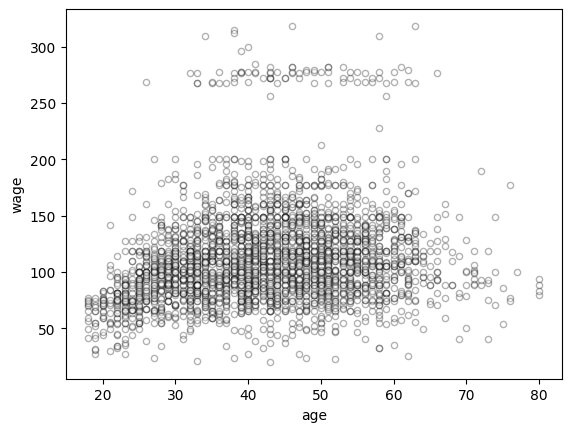

In [92]:
# Scatterplot dos dados
df.plot.scatter('age','wage', color='w', edgecolors='k', alpha=0.3);

Repare que a relação parece ser **complexa** e **não linear**. Ou seja:
* Forma matemática: "A relação parece ser não linear."
* Dificuldade em descrever/modelar linearmente: "A relação parece ser complexa."
  * Nos chama atenção que parece existir uma separação entre salário acima e abaixo de 250, não?

***Variáveis***

Temos a renda ($y$), a idade ($X$), e vamos criar uma nova variável de resultado indicativa/binária ($y01$) que será "1" se a renda for maior que 250.000 USD, e "0" caso contrário (e adicionar ao datafrane df).

In [93]:
X = df['age']
y = df['wage']
df['y01'] = (df.wage > 250).map({False:0, True:1}).values
y01 = df['y01']

Vamos expandir nossos polinômios de regressão linear de diferentes graus: de 1 a 5.

In [94]:
X_poly1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X_poly2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X_poly3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X_poly4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X_poly5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

***OBS:*** O Scikit-Learn espera que as entradas sejam uma matriz de forma (*n_amostras, n_características*).
Mesmo com apenas uma variável, você precisa informar como (*n_amostras, 1*), e não apenas como (*n_amostras,*).

```python	
 array([[25],
       [30],
       [35],
       [40],
       ...])
```
Por isso, precisamos usar o método `.reshape()` para transformar a variável em uma matriz de duas dimensões. O método `reshape(-1, 1)` transforma a variável em uma matriz com uma coluna e tantas linhas quantas forem necessárias.


Se executarmos uma regressão linear em uma expansão polinomial de 4 graus de $age$, isso é o que parece:

In [96]:
# rodar o OLS no polinomio de grau 4
ols_poly4 = sm.OLS(y, X_poly4).fit()
print(ols_poly4.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                seg, 19 mai 2025   Prob (F-statistic):           2.77e-57
Time:                        16:08:52   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

Você poderia ter feito a análise da forma manual:

In [97]:
# Outra forma de fazer o mesmo processo "forma manual" Versão 2 (v2)
ols_poly4_v2 = sm.OLS.from_formula('wage ~ age + I(age**2) + I(age**3) + I(age**4)', data=df).fit()
print(ols_poly4_v2.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                seg, 19 mai 2025   Prob (F-statistic):           2.77e-57
Time:                        16:08:55   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -184.1542     60.040     -3.067      

OBS: `I(...)` diz ao interpretador de fórmulas: “avalie isso como uma expressão Python comum”

### 3. Medidas de Ajuste

Agora os coeficientes individuais **não são de particular interesse**. Nosso principal objetivo é **capturar da melhor forma possível a relação entre `age` e `wage`**. Mas como escolher entre diferentes polinômios?

Vamos comparar modelos com diferentes graus polinomiais. Para cada regressão, analisaremos um conjunto de métricas de desempenho.

***Critérios para prever uma variável contínua***

- **MAE (Mean Absolute Error)**  
  $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$  
  Interpretação: quanto **menor**, melhor.

- **MSE (Mean Squared Error)**  
  $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$  
  Interpretação: quanto **menor**, melhor.

- **RMSE (Root Mean Squared Error)**  
  $$RMSE = \sqrt{MSE}$$  
  Interpretação: quanto **menor**, melhor.

- **R² (Coeficiente de Determinação)**  
  $$R^2 = 1 - \frac{SSR}{SST}$$  
  onde $SSR$ é a soma dos quadrados dos resíduos e $SST$ é a soma total dos quadrados.  
  Interpretação: quanto **maior**, melhor.

- **R² ajustado**  
  $$R^2_{\text{ajustado}} = 1 - \left(1 - R^2\right) \frac{n - 1}{n - k - 1}$$  
  onde $k$ é o número de variáveis independentes.  
  Interpretação: quanto **maior**, melhor. O R² ajustado penaliza a adição de variáveis irrelevantes.


***Critérios baseados em erro de predição***

Esses são úteis quando o foco está na **precisão preditiva fora da amostra**:

- **MAPE (Mean Absolute Percentage Error)**  
  $$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$$  
  Interpretação: quanto **menor**, melhor.  
  Obs: sensível quando $y_i$ se aproxima de zero.


***Critérios de complexidade e ajuste penalizado***

Esses critérios penalizam modelos muito complexos, ajudando a evitar **overfitting**:

- **AIC (Akaike Information Criterion)**  
  $$AIC = 2k - 2 \ln(L)$$  
  onde $k$ é o número de parâmetros e $L$ é a verossimilhança do modelo.  
  Interpretação: quanto **menor**, melhor.

- **BIC (Bayesian Information Criterion)**  
  $$BIC = k \ln(n) - 2 \ln(L)$$  
  onde $k$ é o número de parâmetros e $n$ é o número de observações.  
  Interpretação: quanto **menor**, melhor.

Essas duas métricas ajudam a escolher o grau polinomial que oferece o melhor equilíbrio entre **qualidade de ajuste** e **simplicidade do modelo**, mitigando o risco de **overfitting**.


OBS1: **overfitting**: Overfitting significa que o modelo ficou bom demais para os dados da amostra, capturando não só o padrão verdadeiro, mas também o ruído aleatório.

OBS2: **verossimilhança (likelihood) do modelo**: ferramenta matemática que usamos para estimar os parâmetros da regressão. Busca responder: "Se eu assumo que os dados seguem uma distribuição com certos parâmetros, qual a probabilidade de ter observado exatamente os dados que observei?" A regressão é um modelo estatístico. A verossimilhança é uma técnica para estimar os parâmetros desse modelo. 
  * No caso da regressão linear, se os erros forem normais, os estimadores de Mínimos Quadrados (OLS) são iguais aos estimadores de Máxima Verossimilhança (MLE).
  * Em modelos mais gerais (como Poisson, Logit, Probit, etc.), OLS não serve → usamos MLE, que depende da verossimilhança.

In [98]:
# Run regressions
fit_1 = sm.OLS(y, X_poly1).fit()
fit_2 = sm.OLS(y, X_poly2).fit()
fit_3 = sm.OLS(y, X_poly3).fit()
fit_4 = sm.OLS(y, X_poly4).fit()
fit_5 = sm.OLS(y, X_poly5).fit()

Rotina para calcular as métricas de ajuste:

In [99]:
def print_metrics(y_true, y_pred, X, fit, label):
    n = len(y_true)
    k = X.shape[1] - 1  # subtrai 1 para ignorar o intercepto
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true)))

    # AIC e BIC vindos do statsmodels
    aic = fit.aic
    bic = fit.bic

    print(f'{label}')
    print(f'  MAE        : {mae:.2f}')
    print(f'  MSE        : {mse:.2f}')
    print(f'  RMSE       : {rmse:.2f}')
    print(f'  R²         : {r2:.4f}')
    print(f'  R² ajustado: {r2_adj:.4f}')
    print(f'  MAPE       : {mape:.4f}')
    print(f'  AIC        : {aic:.2f}')
    print(f'  BIC        : {bic:.2f}')
    print()

In [100]:
# Organizar os resultados e matrizes
fits = [fit_1, fit_2, fit_3, fit_4, fit_5]
X_polys = [X_poly1, X_poly2, X_poly3, X_poly4, X_poly5]

# Imprimir as métricas
for i, (fit, X_poly) in enumerate(zip(fits, X_polys), 1):
    print_metrics(y, fit.fittedvalues, X_poly, fit, f'Grau {i}')

Grau 1
  MAE        : 28.77
  MSE        : 1674.07
  RMSE       : 40.92
  R²         : 0.0383
  R² ajustado: 0.0380
  MAPE       : 0.2918
  AIC        : 30786.67
  BIC        : 30798.69

Grau 2
  MAE        : 27.77
  MSE        : 1597.81
  RMSE       : 39.97
  R²         : 0.0821
  R² ajustado: 0.0815
  MAPE       : 0.2788
  AIC        : 30648.80
  BIC        : 30666.82

Grau 3
  MAE        : 27.73
  MSE        : 1592.56
  RMSE       : 39.91
  R²         : 0.0851
  R² ajustado: 0.0842
  MAPE       : 0.2781
  AIC        : 30640.92
  BIC        : 30664.95

Grau 4
  MAE        : 27.70
  MSE        : 1590.53
  RMSE       : 39.88
  R²         : 0.0863
  R² ajustado: 0.0850
  MAPE       : 0.2779
  AIC        : 30639.11
  BIC        : 30669.14

Grau 5
  MAE        : 27.71
  MSE        : 1590.11
  RMSE       : 39.88
  R²         : 0.0865
  R² ajustado: 0.0850
  MAPE       : 0.2780
  AIC        : 30640.30
  BIC        : 30676.34



Melhorias Marginais: Conforme o grau aumenta de 1 para 5:
* As métricas de erro (MAE, MSE, RMSE, MAPE) melhoram levemente.
* R² e R² ajustado também aumentam, indicando melhor explicação da variabilidade.
* Mas os ganhos são cada vez menores, sugerindo retorno decrescente ao aumentar a complexidade.

AIC e BIC:
* O AIC atinge o menor valor no grau 4.
* O BIC, mais penalizador, também é menor no grau 4.

Embora modelos mais complexos consigam representar melhor a amostra, eles nem sempre generalizam melhor. AIC e BIC nos ajudam a identificar quando o ganho de explicação começa a ser superado pelo risco de overfitting. Neste caso, grau 4 representa o melhor equilíbrio entre ajuste e simplicidade.


Isso indica que grau 4 parece ser o ponto ótimo, balanceando ajuste e complexidade.

In [101]:
# Set polynomial X to 4th degree
X_poly = X_poly4

### 4. Regressões da Família Binomial

Uma regressão da **família binomial** é um tipo de modelo estatístico pertencente à classe dos **Modelos Lineares Generalizados (GLMs)**, adequado quando a ***variável dependente é binária*** (ou seja, assume dois valores, como 0 e 1). O nome "binomial" se refere ao fato de que a variável resposta segue uma **distribuição binomial condicionalmente às covariáveis**.


***Características Gerais***

- **Distribuição da família exponencial**: Binomial  
- **Variável resposta**:
  - Binária (ex: sucesso/fracasso, 1/0)
  - Ou proporção (ex: número de sucessos em $n$ tentativas)
- **Função de ligação** (*link function*): diversas, como `logit`, `probit`, `cloglog`, `identity`, etc.
- **Objetivo**: modelar a probabilidade de sucesso $ \Pr(Y = 1 \mid X) $ como uma função das covariáveis $X$


***Forma Geral do Modelo***

Ao contrário da regressão linear clássica, os GLMs utilizam uma função de ligação $ g(\cdot) $ para conectar a média da variável resposta ao preditor linear:

$$
g\left( \mathbb{E}[Y_i \mid X_i] \right) = \beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k
$$

No caso da regressão logística (link `logit`), essa função de ligação é a **Probabilidade Logística**.


### 4.1. Funções de Ligação para a Família Binomial

A escolha da função de ligação determina como a regressão transforma a média condicional para ser modelada como uma combinação linear dos regressores. Algumas funções de ligação comuns para a família binomial são:


In [102]:
# List link functions for the Binomial family
sm.families.family.Binomial.links

[statsmodels.genmod.families.links.Logit,
 statsmodels.genmod.families.links.probit,
 statsmodels.genmod.families.links.cauchy,
 statsmodels.genmod.families.links.Log,
 statsmodels.genmod.families.links.CLogLog,
 statsmodels.genmod.families.links.LogLog,
 statsmodels.genmod.families.links.identity]

### 4.2. Regressão Logística (link logit)

A função `logit` assume que o termo de erro segue uma distribuição Valor Extremo Tipo I (ou Gumbel). Nesse caso, a probabilidade condicional de sucesso é modelada por:

$$

Pr(Y=1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k)}} = \frac{e^{(\beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k)}}{1 + e^{(\beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k)}}

$$


Se ao invés disso assumíssemos que os erros seguem uma distribuição normal padrão, obteríamos a regressão probit.

Agora, em nossa análise, vamos modelar a variável binária `y01` em função de `age`. Vamos usar a função `logit` como função de ligação.

In [103]:
# Configurar o link logit para GLM com família binomial
logit_link = sm.families.Binomial(sm.genmod.families.links.logit())

# Estimar o modelo (ex: y01 como binária, X_poly como polinômios de age)
logit_poly = sm.GLM(y01, X_poly, family=logit_link).fit()

# Exibir os coeficientes
print(logit_poly.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    y01   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                seg, 19 mai 2025   Deviance:                       701.22
Time:                        16:09:17   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

Ou seja:
* $const = -109.5530$
* $x1    =   8.9950$
* $x2    =  -0.2816$
* $x3    =   0.0039$
* $x4    =  -1.949e-05$

logo, a equação da regressão logística seria:
$$
Pr(Y=1 \mid X) = \frac{e^{-109.5530 + 8.9950 x_{i} - 0.2816 x_{i}^2 + 0.0039 x_{i}^3 - 1.949e-05 x_{i}^4}}{1 + e^{-109.5530 + 8.9950 x_{i} - 0.2816 x_{i}^2 + 0.0039 x_{i}^3 - 1.949e-05 x_{i}^4}}
$$


depois plotaremos. Lembre que a relação não é linear, e sim logit.

***Comparação com Modelos Lineares***

Qual é a diferença com o modelo linear?

In [104]:
# Run OLS regression with binary outcome
ols_poly = sm.OLS(y01, X_poly).fit()
print(ols_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                    y01   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.158
Date:                seg, 19 mai 2025   Prob (F-statistic):            0.00232
Time:                        16:09:20   Log-Likelihood:                 1246.9
No. Observations:                3000   AIC:                            -2484.
Df Residuals:                    2995   BIC:                            -2454.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1126      0.240     -0.468      0.6

A magnitude dos coeficientes é diferente, mas os sinais são os mesmos.

***Dados de plotagem e previsões***

Vamos traçar as curvas estimadas em relação à distribuição de dados.

In [105]:
# Generate predictions
x_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
X_poly_test = PolynomialFeatures(4).fit_transform(x_grid)
y_hat1 = sm.OLS(y, X_poly).fit().predict(X_poly_test)
y01_hat1 = logit_poly.predict(X_poly_test)

In [106]:
# Ploimport matplotlib.pyplot as plt

def plot_predictions(X, y, x_grid, y_hat1, y01_hat1, title=''):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # OLS plot
    ax[0].scatter(X, y, color='w', edgecolor='k', alpha=0.3)
    ax[0].plot(x_grid, y_hat1, color='blue', label='OLS Prediction')
    ax[0].set_title(title + ' - OLS')
    ax[0].set_xlabel('Age')
    ax[0].set_ylabel('Wage')
    ax[0].legend()

    # Logistic plot
    ax[1].scatter(X, (y > 250).astype(int), color='w', edgecolor='k', alpha=0.3)
    ax[1].plot(x_grid, y01_hat1, color='red', label='Logistic Prediction')
    ax[1].set_title(title + ' - Logistic')
    ax[1].set_xlabel('Age')
    ax[1].set_ylabel('Pr(Wage > 250)')
    ax[1].set_ylim(0, 0.2)  # <== ajuste da escala do eixo y
    ax[1].legend()

    plt.tight_layout()
    plt.show()

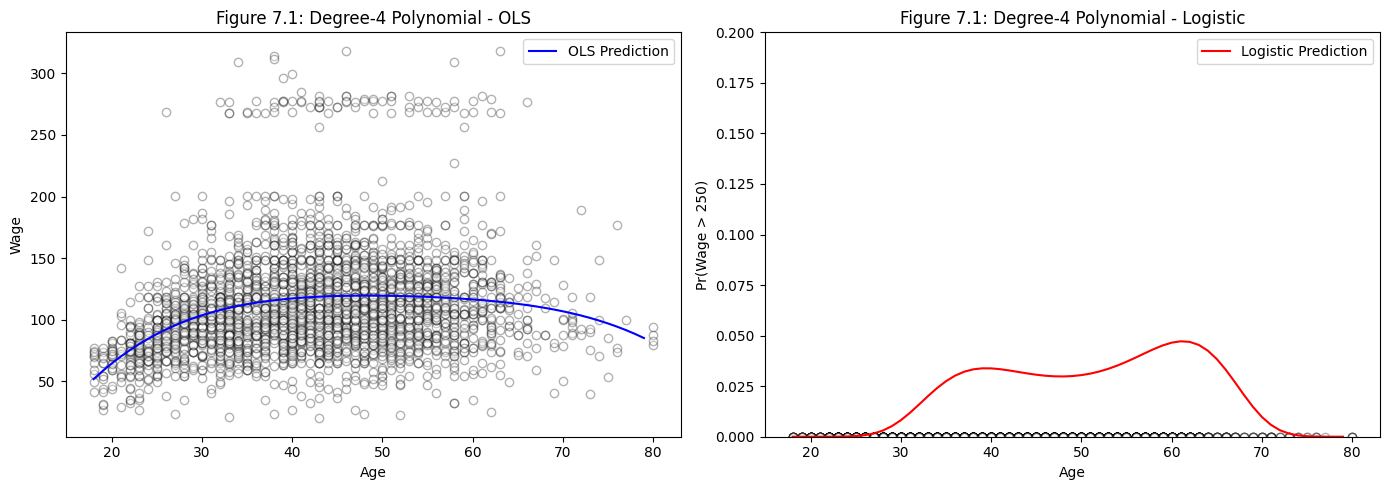

In [107]:
plot_predictions(X, y, x_grid, y_hat1, y01_hat1, 'Figure 7.1: Degree-4 Polynomial')

O **uso de funções polinomiais** das variáveis preditoras ***em um modelo linear impõe uma estrutura global à relação não linear*** entre $age$ e a variável resposta $wage$. Isso significa que **uma pequena mudança em uma parte do domínio pode afetar a forma da função em todo o intervalo**.

Como alternativa, podemos utilizar ***funções degrau (Step Functions)***, que evitam a imposição dessa estrutura global.

Por exemplo, podemos dividir o intervalo de age em faixas (ou "caixas") e estimar uma constante diferente para cada faixa. Isso nos permite capturar mudanças abruptas ou relações locais sem impor suavidade ou continuidade entre os intervalos.

### 5. Step Functions (Funções Degrau/Escalonadas)

As ***Step Functions*** (funções escalonadas/degrau) dividem a faixa de uma variável $X$ em "caixas" (bins) e ajustam uma constante diferente em cada uma dessas bins, evitando impor uma estrutura global.

Logo, construir uma função degrau significa, primeiro, escolher $ K $ pontos de corte $ c_1, c_2, \ldots, c_K $ no intervalo da variável $ \text{age} $, e então definir $ K + 1 $ variáveis indicadoras da seguinte forma:

$$
\begin{aligned}
C_0(\text{age}) &= \mathbb{I}(\text{age} < c_1) \\
C_1(\text{age}) &= \mathbb{I}(c_1 \leq \text{age} < c_2) \\
C_2(\text{age}) &= \mathbb{I}(c_2 \leq \text{age} < c_3) \\
&\vdots \\
C_{K-1}(\text{age}) &= \mathbb{I}(c_{K-1} \leq \text{age} < c_K) \\
C_K(\text{age}) &= \mathbb{I}(\text{age} \geq c_K)
\end{aligned}
$$

onde $ \mathbb{I}(\cdot) $ é a **função indicadora**, que assume valor 1 se a condição lógica for verdadeira, e 0 caso contrário.

Dessa forma, a função de regressão resultante estima **uma constante separada para cada faixa etária definida pelos cortes**, permitindo capturar variações locais sem impor continuidade ou suavidade entre os intervalos.


In [108]:
# 1. Criar a variável categórica com os cortes de age em 4 faixas (bins)
df["age_cut"] = pd.cut(df["age"], bins=4)

In [109]:
# ver quais são os nomes das faixas
df["age_cut"].cat.categories

IntervalIndex([(17.938, 33.5], (33.5, 49.0], (49.0, 64.5], (64.5, 80.0]], dtype='interval[float64, right]')

In [110]:
# 2. Criar dummies e garantir que são inteiros
dummies = pd.get_dummies(df["age_cut"], prefix="age_bin", drop_first=False).astype(int)
# 3. Juntar ao df
df = df.join(dummies)

In [111]:
df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,y01,age_cut,"age_bin_(17.938, 33.5]","age_bin_(33.5, 49.0]","age_bin_(49.0, 64.5]","age_bin_(64.5, 80.0]"
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,0,"(17.938, 33.5]",1,0,0,0
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,0,"(17.938, 33.5]",1,0,0,0
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,0,"(33.5, 49.0]",0,1,0,0
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,0,"(33.5, 49.0]",0,1,0,0
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154,0,"(49.0, 64.5]",0,0,1,0


***Regressão Stepwise*** (Degrau/Escalonadas)

Repare que vamos deixar nosso modelo "model_step" para ser usado posteriormente.

In [112]:
# Vamos renomear as colunas para facilitar o uso
df = df.rename(columns={"age_bin_(17.938, 33.5]": "age_bin_1"})
df = df.rename(columns={"age_bin_(33.5, 49.0]": "age_bin_2"})
df = df.rename(columns={"age_bin_(49.0, 64.5]": "age_bin_3"})
df = df.rename(columns={"age_bin_(64.5, 80.0]": "age_bin_4"})

# devido à questão de colinearidade, vamos retirar a variável age_bin_1 (será o intercepto)
model_step = sm.OLS.from_formula('wage ~ 1 + age_bin_2 + age_bin_3 + age_bin_4', data=df).fit()

print(model_step.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.58
Date:                seg, 19 mai 2025   Prob (F-statistic):           1.13e-41
Time:                        16:09:46   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.1584      1.476     63.790      0.0

A partir do resultado da regressão, podemos ver que os coeficientes de bins são significativos.


| Faixa Etária	| Coeficiente	| Interpretação
|--------------|----------------|----------------|
| age_bin_1 (base)	| 94.16	| Faixa de referência: salário médio estimado ≈ R$ 94,16| 
| age_bin_2	| +24.05	| Salário médio ≈ 94.16 + 24.05 = R$ 118,21| 
| age_bin_3	| +23.66	| Salário médio estimado ≈ 94.16 + 23.66 = R$ 117,82 (significativo) |
| age_bin_4	| +7.64	| Salário médio estimado ≈ 94.16 + 7.64 = R$ 101,80 (não significativo) |



Agora, queremos traçar uma curva suave ou uma função degrau estimada ao longo da idade, mesmo que os dados originais estejam irregulares, com pontos dispersos.

Como fazer isso?

Vamos gerar valores constantes dentro de cada faixa etária, ou seja: é uma função escada (piecewise constant function).

Para plotar essa escada de forma contínua, precisamos:
* Criar uma sequência de valores age (Grid/Grade de valores: o $x_grid$).
* Atribuir a cada valor do grid a sua faixa correspondente.
* Criar as variáveis dummy (igual ao que está no modelo).
* Prever os salários com model_step.predict(...).
* Plotar os pares (x_grid, y_hat).

In [113]:
# 1. Criar a grade de valores de idade
x_grid = np.linspace(df["age"].min(), df["age"].max(), 100)
df_grid = pd.DataFrame({"age": x_grid})

* Geramos 100 valores igualmente espaçados entre o valor mínimo e o valor máximo da variável age.
* Isso serve como uma grade para traçar uma curva suave de salários previstos por idade, mesmo que os dados originais sejam discretizados.

In [114]:
# 2. Usar os mesmos bins da regressão original
df_grid["age_cut"] = pd.cut(df_grid["age"], bins=df["age_cut"].cat.categories)

# 3. Gerar dummies e renomear
dummies_grid = pd.get_dummies(df_grid["age_cut"], prefix="age_bin").astype(int)
rename_dict = {
    "age_bin_(17.938, 33.5]": "age_bin_1",
    "age_bin_(33.5, 49.0]": "age_bin_2",
    "age_bin_(49.0, 64.5]": "age_bin_3",
    "age_bin_(64.5, 80.0]": "age_bin_4"
}
dummies_grid = dummies_grid.rename(columns=rename_dict)

# 4. Juntar ao df_grid
df_grid = pd.concat([df_grid, dummies_grid], axis=1)


In [115]:
df_grid

,age,age_cut,age_bin_1,age_bin_2,age_bin_3,age_bin_4
0,18.000000,"(17.938, 33.5]",1,0,0,0
1,18.626263,"(17.938, 33.5]",1,0,0,0
2,19.252525,"(17.938, 33.5]",1,0,0,0
3,19.878788,"(17.938, 33.5]",1,0,0,0
4,20.505051,"(17.938, 33.5]",1,0,0,0
...,...,...,...,...,...,...
95,77.494949,"(64.5, 80.0]",0,0,0,1
96,78.121212,"(64.5, 80.0]",0,0,0,1
97,78.747475,"(64.5, 80.0]",0,0,0,1
98,79.373737,"(64.5, 80.0]",0,0,0,1


In [116]:
# 5. Adicionar colunas ausentes com valor zero
#for col in ["age_bin_2", "age_bin_3", "age_bin_4"]:
#    if col not in df_grid.columns:
#        df_grid[col] = 0

# 6. Prever salários (modelo espera fórmula com Intercept)
y_hat2 = model_step.predict(df_grid)

Os resultados utilizando os dados do grid foram salvos em "y_hat2". Lembre que esse modelo "model_step" é o modelo de regressão linear com funções degrau.

**Regressão Logística em Etapas**

Vamos executar novamente uma regressão logística, já que nosso resultado é binário, podemos considerar uma função não linear "binomial" para construir a análise escalonada. Lembre que estamos considerando os dados suaves (*df_grid*)


In [117]:
# Configurar o link logit para GLM com família binomial
logit_link = sm.families.Binomial(sm.genmod.families.links.logit())

logit_step = sm.GLM.from_formula('y01 ~ 1 + age_bin_2 + age_bin_3 + age_bin_4', data=df, family=logit_link).fit()

y01_hat2 = logit_step.predict(df_grid)

print(logit_step.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    y01   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -354.85
Date:                seg, 19 mai 2025   Deviance:                       709.69
Time:                        16:10:38   Pearson chi2:                 3.00e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.006923
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.0039      0.449    -11.152      0.0

**Plotagem**

Como é a função prevista?

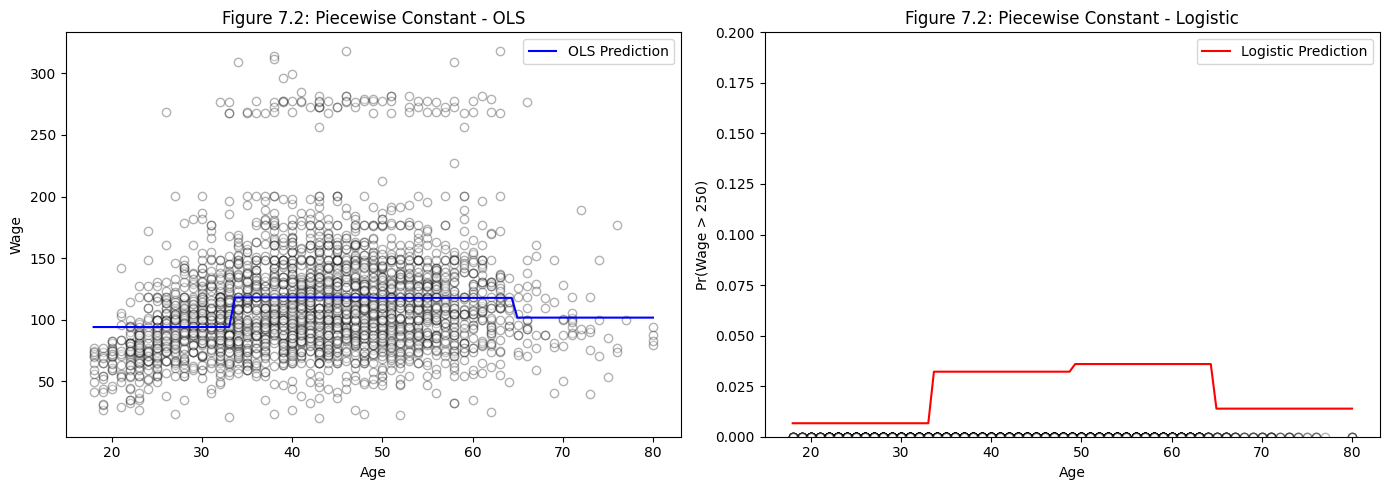

In [118]:
plot_predictions(X, y, x_grid, y_hat2, y01_hat2, 'Figure 7.2: Piecewise Constant')

### 6. Spline Regression (Regressão com Splines)

A ***spline regression***, ou regressão polinomial por partes (***piecewise polynomial regression***), consiste em ajustar diferentes polinômios a diferentes intervalos da variável explicativa $x$. Essa abordagem permite capturar melhor os comportamentos não lineares que mudam ao longo do domínio de $x$.

Termo "Spline":
* "curva segmentada suave"
* "pedaço de uma curva suave"
* "Segmentoo de uma curva suave"

Diferente de um polinômio global (que impõe a mesma curvatura em todo o domínio), a regressão com "spline" **divide o espaço de $x$ em segmentos** e ajusta um polinômio (tipicamente de grau baixo) em cada um deles. ***Os pontos que separam os segmentos são chamados de **nós** (*knots*)***.

Esses nós (*knots points*) que determinam onde a função muda de forma.

#### Exemplo com um único nó $c$:

$$
y_i =
\begin{cases}
\beta_{01} + \beta_{11}x_i + \beta_{21}x_i^2 + \beta_{31}x_i^3 + \epsilon_i, & \text{se } x_i < c \\\\
\beta_{02} + \beta_{12}x_i + \beta_{22}x_i^2 + \beta_{32}x_i^3 + \epsilon_i, & \text{se } x_i \geq c
\end{cases}
$$

Assim, temos **dois conjuntos de coeficientes**, um para cada subintervalo de $x$.

#### Propriedades:

- Quanto **mais nós**, maior a flexibilidade da spline.
- Splines de grau 1: ***piecewise linear regression***
- Splines de grau 3 (cúbicas): muito comuns por seu bom equilíbrio entre suavidade e flexibilidade.
- Para evitar descontinuidades, é comum exigir que as funções spline sejam **contínuas e suavemente diferenciáveis** nos nós (ex: splines cúbicas naturais).


***Caso geral***

Vamos formalizar um pouco mais a ideia de splines. Cada função base B-spline atua localmente sobre o eixo $x$. Elas são como "pedaços" que, combinados com pesos (os coeficientes da regressão), constroem uma curva suave por partes.

* curva a ser estimada:

$$
\hat{y}(x) = \beta_0 + \beta_1 B_1(x) + \beta_2 B_2(x) + \ldots + \beta_k B_k(x)
$$

Onde:

- $\hat{y}(x)$ é a previsão da variável dependente (por exemplo, salário) para um valor específico de $x$ (por exemplo, idade);
- $\beta_0$ é o intercepto;
- $\beta_j$ são os coeficientes estimados;
- $B_j(x)$ são as funções base B-spline, localizadas ao longo do eixo $x$;
- $k$ é o número de funções base utilizadas;
- $x$ é a variável explicativa (como idade).

*OBS: Normalmente o número de funções base é dado pela soma do número de nós e do grau do polinômio. Por exemplo, se tivermos 4 nós e um polinômio cúbico (grau 3), teremos 7 funções base.*


**Em resumo:** cada função base $B_j(x)$ atua localmente em uma faixa de valores de $x$, e a curva final é obtida somando essas contribuições ponderadas.  
**Você interpreta a spline visualmente**, analisando o formato da curva $\hat{y}(x)$ ao longo de $x$ — e não os coeficientes $\beta_j$ isoladamente.


Abaixo comparamos quatro tipos de splines, aplicados à relação entre $age$ e $wage$ em uma subamostra :

1. **Cúbico por partes descontínuo**  
   - Polinômios cúbicos são ajustados em diferentes regiões, mas **sem exigir continuidade** nos nós.
   - Isso pode gerar quebras visíveis na função.

2. **Cúbico por partes contínuo**  
   - Similar ao anterior, mas força **continuidade nos nós**.
   - A curva é mais suave e coerente.

3. **Quadrático contínuo**  
   - Um spline de grau 2 (quadrático), com suavidade entre os trechos.
   - Menos flexível que o cúbico, mas mais interpretável.

4. **Linear contínuo por partes**  
   - O ajuste é feito com **linhas retas conectadas nos nós**.
   - É o spline mais simples e fácil de interpretar.


Vamos selecionar uma subamostra para tornar a análise visual mais clara.

In [119]:
# Subamostra com os 80 primeiros dados
df_short = df.iloc[:80,:]
X_short = df_short.age
y_short = df_short.wage

OBS: `.iloc[:80, :]` seleciona as primeiras 80 linhas (0 a 79) e todas as colunas (:). Assim, `df_short` é uma subamostra com as primeiras 80 pessoas da base.

Agora vamos criar uma grade (grid) de valores de idade, que será usada para prever e traçar curvas suavizadas (como as splines) ao longo do eixo `x`.

In [120]:
x_grid_short = np.arange(df_short.age.min(), df_short.age.max()+1).reshape(-1,1)

* `df_short.age.min()` e `df_short.age.max() + 1`:
  * Define o intervalo da variável age na subamostra df_short.
  * O +1 é usado para garantir que o valor máximo seja incluído no grid (já que np.arange exclui o valor final).

* `np.arange(...)`: Gera um array de números inteiros entre min_age e max_age + 1, com passo 1.
  * Ex: se age vai de 18 a 65, isso gera [18, 19, 20, ..., 65].

* `.reshape(-1, 1)`: Transforma esse vetor 1D em uma matriz coluna (shape (n, 1)), que é o formato exigido por muitas funções do scikit-learn, patsy, etc.

* O -1 diz: “calcule automaticamente o número de linhas conforme necessário”.

In [121]:
# 1. Discontinuous piecewise cubic
spline1 = "bs(x, knots=(50,50,50,50), degree=3, include_intercept=False)"

# 2. Continuous piecewise cubic
spline2 = "bs(x, knots=(50,50,50), degree=3, include_intercept=False)"

# 3. Quadratic (continuous)
spline3 = "bs(x, knots=(%s,%s), degree=2, include_intercept=False)" % (min(df.age), min(df.age))

# 4. Continuous piecewise linear
spline4 = "bs(x, knots=(%s,50), degree=1, include_intercept=False)" % min(df.age)

a função `bs(...)` da biblioteca patsy, que cria B-splines; $bs(x, knots=..., degree=..., include_intercept=...)$

* x: a variável base (idade, por exemplo)
* knots: posições dos nós (onde os trechos do polinômio mudam)
* degree: grau do polinômio (1 = linear, 2 = quadrático, 3 = cúbico)
* include_intercept=False: evita que o spline tenha um intercepto embutido, já que ele será tratado separadamente.

Com relação ao nossos exemplos:
* Discontinuous piecewise cubic
  * Quando estamos pedindo uma spline cúbica (degree=3) com 4 nós coincidentes em 50.
  * Isso força o spline a ser discontínuo em 50 (porque os nós repetidos quebram a suavidade).
  * O resultado é uma curva cúbica por partes, com descontinuidade evidente em x = 50.
* Continuous piecewise cubic
  * três nós coincidentes em 50 (em vez de quatro).
  * Isso preserva a continuidade da função e suas derivadas até segunda ordem — que é o padrão para splines cúbicos.Esse é um spline cúbico com transição suave em x = 50. 
* Quadratic (continuous)
  * com dois nós no menor valor de age (%s,%s)
* Continuous piecewise linear
  * Cria uma spline de grau 1 (linear) com dois nós: o mínimo de age e 50.


***Regra Matemática para Continuidade de Splines***

* Se o nó ***c*** aparece ***m*** vezes, então a função spline resultante será $C^{k - m}$ contínua no ponto ***c***, onde:
  * $k$ é o grau do polinômio;
  * $m$ é a multiplicidade do nó (quantas vezes ele aparece).

**Exemplo:**
- Grau $k = 3$ (spline cúbica)
- Nó repetido 4 vezes: $(50, 50, 50, 50)$ → $m = 4 $
- $C^{r}$ é a classe de continuidade. 
- Logo, $C^{3 - 4} = C^{-1}$ → ou seja, **sem continuidade**: há **uma descontinuidade visível** na curva em $x = 50$.
  - $C^0$: contínua;
  - $C^1$: contínua e com derivada contínua;
  - $C^2$: contínua e com derivada de 1ª e 2ª ordem contínuas;
  - $C^3$: contínua e com derivadas até a 3ª ordem contínuas;
  - ...
  - $C^{-1}$: não contínua – isto é, existe uma descontinuidade.


Vou rodar uma regressão e mostrar sua saída, apenas para ilustrar o que acontece com os coeficientes.

In [122]:
spline = "bs(x, knots=(50,50,50,50), degree=3, include_intercept=False)"

# Gerar a matriz transformada de X_short
transformed_x = dmatrix(spline, {"x": X_short}, return_type='dataframe', )

spline_manual = sm.GLM(y_short, transformed_x).fit()

print(spline_manual.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                   80
Model:                            GLM   Df Residuals:                       72
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          2401.0
Method:                          IRLS   Log-Likelihood:                -420.65
Date:                seg, 19 mai 2025   Deviance:                   1.7287e+05
Time:                        16:12:04   Pearson chi2:                 1.73e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2273
Covariance Type:            nonrobust                                         
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

A ideia é que Splines são ferramentas para flexibilizar o ajuste da curva, não para explicar com precisão o papel individual de cada termo.

Os coeficientes refletem contribuições ponderadas de cada função base na construção da curva final, mas não têm significado econômico direto.

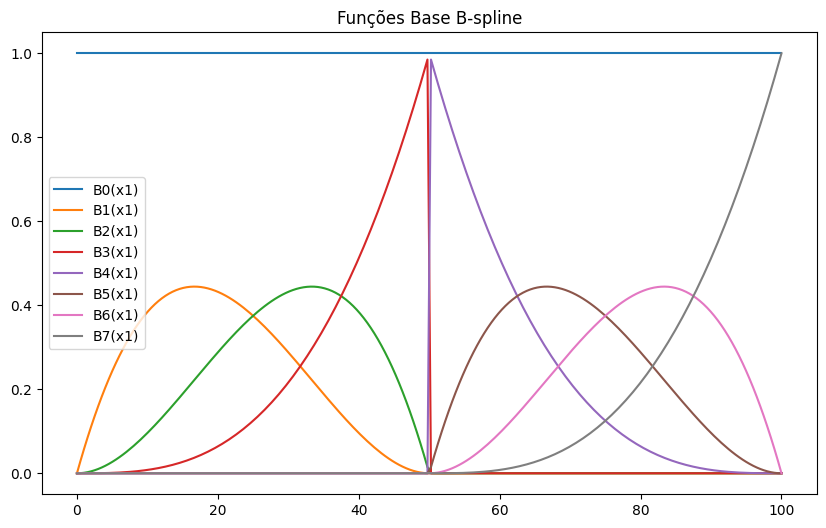

In [123]:
x1 = np.linspace(0, 100, 200)
dm = dmatrix("bs(x1, knots=(50, 50, 50, 50), degree=3, include_intercept=False)", {"x1": x1})

plt.figure(figsize=(10, 6))
for i in range(dm.shape[1]):
    plt.plot(x1, dm[:, i], label=f"B{i}(x1)")
plt.legend()
plt.title("Funções Base B-spline")
plt.show()


Assim, vamos fazer a previsão da curva spline ajustada ao longo de um grid de valores de idade (x_grid_short).

In [124]:
# Gerar a matriz de x_grid_short e prever
X_grid_spline = dmatrix(spline, {"x": x_grid_short}, return_type='dataframe')
y_hat_manual = spline_manual.predict(X_grid_spline)

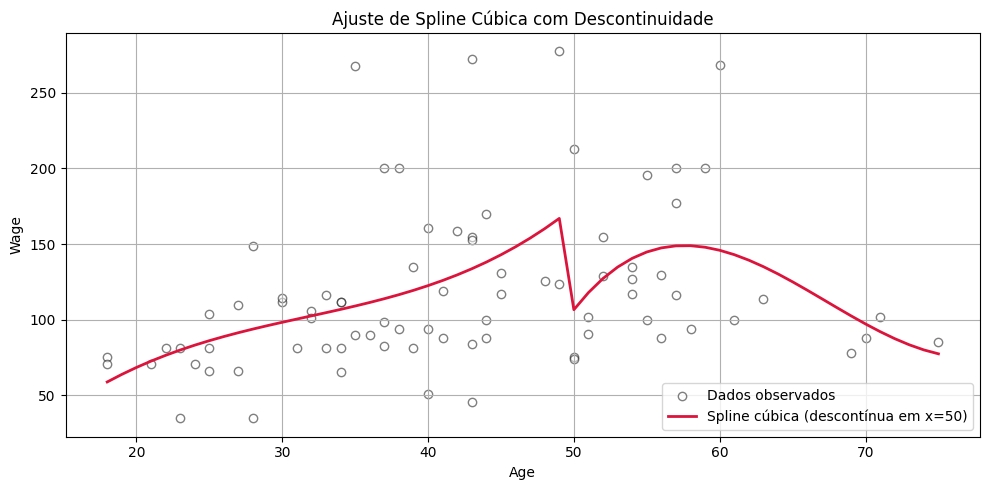

In [125]:
plt.figure(figsize=(10, 5))

# Dados reais (subamostra)
plt.scatter(X_short, y_short, color='w', edgecolor='k', alpha=0.5, label="Dados observados")

# Curva estimada da spline
plt.plot(x_grid_short, y_hat_manual, color='crimson', lw=2, label="Spline cúbica (descontínua em x=50)")

plt.title("Ajuste de Spline Cúbica com Descontinuidade")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Agora vamos criar uma função genérica para ajustar e prever splines com diferentes especificações. Consideramos o ***Modelo linear generalizado (GLM)*** — permite diferentes distribuições para y. No caso, estamos usando GLM sem especificar family, então por padrão ele assume a distribuição normal (Gaussian()) tornando-se um modelo linear clássico (OLS).

In [126]:
# Gerar previsões spline
def fit_predict_spline(spline, X, y, x_grid):
    transformed_x = dmatrix(spline, {"x": X}, return_type='dataframe')
    fit = sm.GLM(y, transformed_x).fit()
    y_hat = fit.predict(dmatrix(spline, {"x": x_grid}, return_type='dataframe'))
    return y_hat

y_hats = [fit_predict_spline(s, X_short, y_short, x_grid_short) for s in [spline1, spline2, spline3, spline4]]

Agora vamos criar uma função geral para criar os gráficos de cada spline.

In [127]:
def plot_splines(df_short, x_grid, y_hats):
    titles = [
        'Discontinuous piecewise cubic spline',
        'Continuous piecewise cubic spline',
        'Quadratic spline (continuous)',
        'Continuous piecewise linear spline'
    ]
    
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    ax = ax.ravel()

    for i in range(4):
        ax[i].scatter(df_short.age, df_short.wage, color='w', edgecolor='k', alpha=0.4)
        ax[i].plot(x_grid, y_hats[i], color='crimson', lw=2)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Age")
        ax[i].set_ylabel("Wage")
    
    plt.tight_layout()
    plt.show()

Plotar:

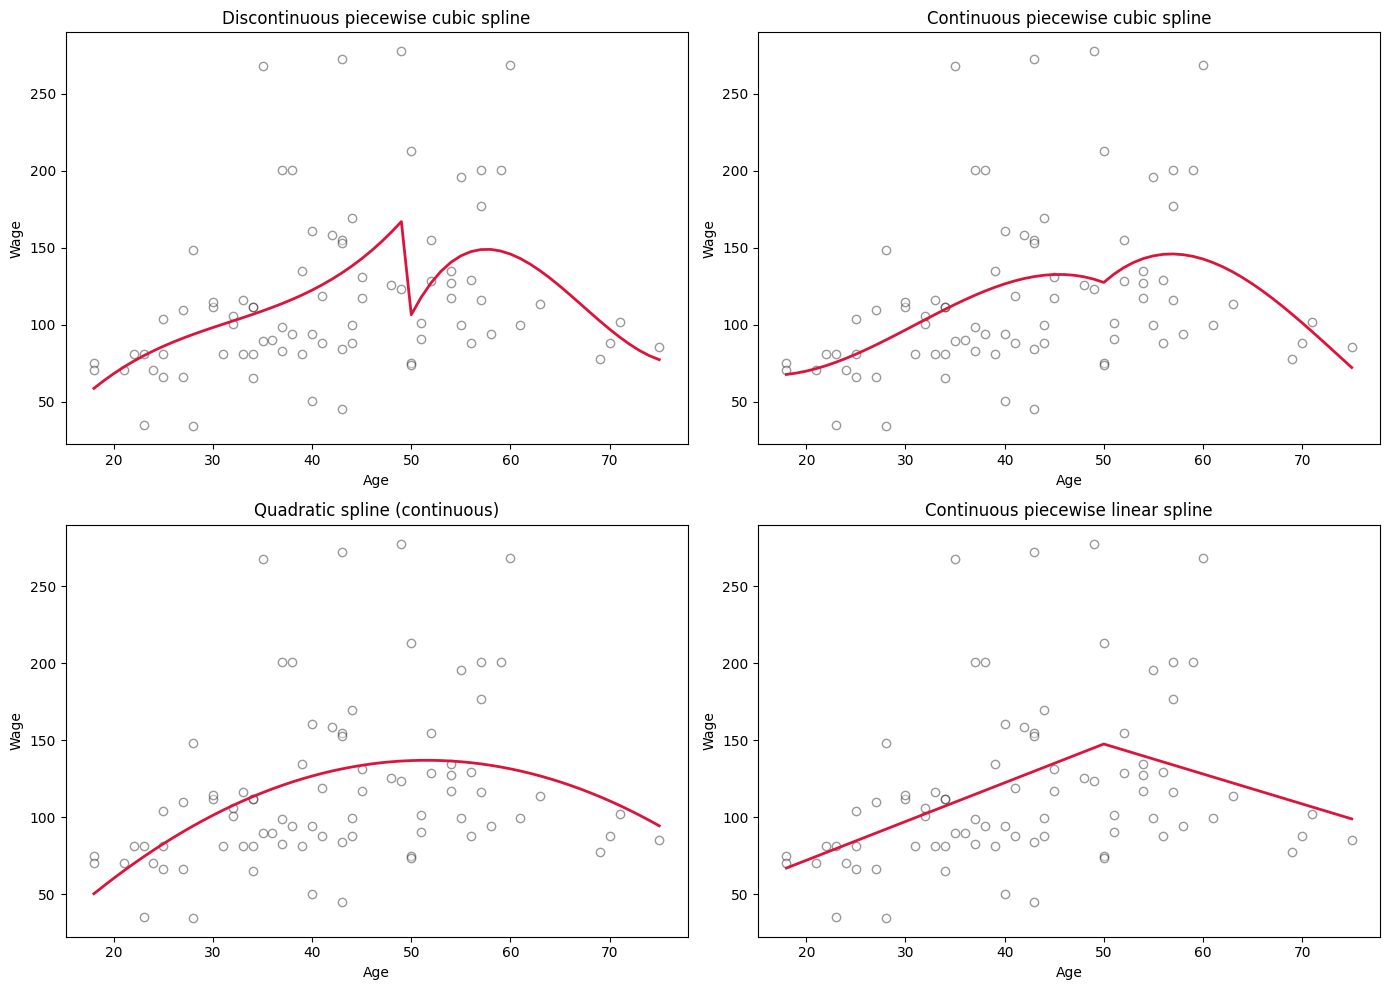

In [128]:
plot_splines(df_short, x_grid_short, y_hats)

***Comentário sobre os quatro modelos spline***

O primeiro gráfico (canto superior esquerdo) mostra uma **spline cúbica com descontinuidade** em `age = 50`.  
Isso nos leva a refletir: *faz sentido esperar uma quebra brusca no salário nessa idade?*  


Geralmente, não queremos que nossa função seja descontínua — a menos que exista uma razão substantiva clara, como uma política de aposentadoria obrigatória ou mudança contratual abrupta, por exemplo.

O segundo gráfico (canto superior direito) apresenta uma **spline cúbica contínua**, mas **não suavemente diferenciável**.  
Isso levanta outra pergunta: *faz sentido que a taxa de crescimento do salário mude bruscamente em `x = 50`?*  
Em alguns casos, isso pode ser razoável, mas se não houver justificativa econômica clara, talvez seja melhor escolher uma função mais suave.

Os dois gráficos inferiores nos mostram opções alternativas:

- O terceiro (esquerda inferior) usa uma **spline quadrática contínua**:  
  fornece uma curva suavemente arredondada, com uma única concavidade.
  
- O quarto (direita inferior) usa uma **spline linear contínua por partes**, com **mudança abrupta na inclinação** em `x = 50`.

A diferença essencial entre os dois últimos é que:
- No modelo quadrático, deixamos os dados guiarem a curvatura;
- No linear por partes, nós impomos o ponto onde a inclinação muda (o "nó").

**Em resumo:**
> A escolha entre diferentes tipos de splines (descontínuas, contínuas, suavemente contínuas) deve refletir:
> - o conhecimento substantivo sobre a variável explicativa (`age`);
> - a necessidade de controle da suavidade;
> - e a desejável interpretabilidade do modelo ajustado.


### 6.1. Splines Cúbicas com Vários Nós

Ao usar **splines cúbicas com múltiplos nós**, estamos construindo uma função que:

- É composta por pedaços de **polinômios cúbicos**;
- Esses pedaços são **costurados suavemente** nos nós;
- O comportamento da curva pode **mudar localmente** em cada subintervalo, mas sempre de forma **suave e contínua**.



In [129]:
# Specifying 3 knots and 3 degrees of freedom
spline5 = "bs(x, knots=(25,40,60), degree=3, include_intercept=False)"
pred5 = fit_predict_spline(spline5, X, y, x_grid)

* `bs(...)` é uma função B-spline do pacote patsy que gera automaticamente as funções base para splines;
* `x` é a variável independente (ex: idade);
* `knots=(25,40,60)` define três nós internos onde a forma do spline pode mudar;
* `degree=3` cria uma spline cúbica (funções polinomiais de grau 3);
* `include_intercept=False` omite o intercepto da base (isso permite que ele seja tratado separadamente, por exemplo, por statsmodels).
* `pred5` conterá as previsões da spline cúbica com 3 nós nos pontos 25, 40 e 60, suavemente conectadas entre si, ao longo dos valores de `x_grid`.

***Onde devemos colocar os nós ao ajustar uma spline?***

A **spline de regressão** é mais flexível nas regiões onde há mais nós, pois, nesses intervalos, os coeficientes dos polinômios podem variar mais rapidamente.

Por isso, uma estratégia é **colocar mais nós onde esperamos maior variação da função**, e menos nós onde a relação entre as variáveis parece mais estável.

Embora essa abordagem baseada em conhecimento prévio possa funcionar bem, na prática é comum **posicionar os nós de forma uniforme**, especialmente quando não temos fortes hipóteses sobre o comportamento da função.

Uma abordagem prática amplamente utilizada é:
- Especificar o número desejado de **graus de liberdade** (Grau de Liberdade = grau do polinômio + número de nós);
- E deixar que o software **posicione automaticamente os nós** nos **quantis uniformemente espaçados** da variável explicativa.

Essa estratégia costuma funcionar bem em muitos contextos empíricos, especialmente com amostras grandes.


In [130]:
# Specifying degree 3 and 6 degrees of freedom 
spline6 = "bs(x, df=6, degree=3, include_intercept=False)"
pred6 = fit_predict_spline(spline6, X, y, x_grid)

***Splines Naturais***

Uma **spline natural** é uma spline de regressão com **restrições de contorno adicionais**:  A curva deve ser **linear fora do intervalo definido pelos nós** — ou seja, quando $x$ está abaixo do menor nó ou acima do maior nó.

* Essas restrições adicionais **reduzem a flexibilidade da spline nas extremidades**, o que traz duas grandes vantagens:
  * **Estabilidade nas bordas**: Evita que a curva "exploda" nos extremos, o que é comum em splines cúbicas não restritas.
  * **Menor risco de overfitting**: Ao restringir o comportamento nas bordas, a spline natural tende a ser **mais conservadora onde temos menos dados**.

***Implementação prática (Python com patsy)***

`cr`: Cubic regression spline natural

In [131]:
# Natural spline with 4 degrees of freedom
spline7 = "cr(x, df=4)"
pred7 = fit_predict_spline(spline7, X, y, x_grid)

Comparação

In [132]:
def compare_predictions(x, y, x_grid, predictions, labels):
    """
    Plota comparações entre múltiplas curvas de previsão e os dados originais.
    
    Parâmetros:
    - x: vetor de entrada original (ex: idade)
    - y: vetor de saída original (ex: salário)
    - x_grid: valores de x nos quais as previsões foram feitas
    - predictions: lista de arrays com as previsões correspondentes a x_grid
    - labels: lista de strings com os nomes das curvas (mesmo comprimento de predictions)
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='w', edgecolor='k', alpha=0.4, label='Dados')
    
    for pred, label in zip(predictions, labels):
        plt.plot(x_grid, pred, label=label, linewidth=2)
    
    plt.title("Comparação entre diferentes splines")
    plt.xlabel("Age")
    plt.ylabel("Wage")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

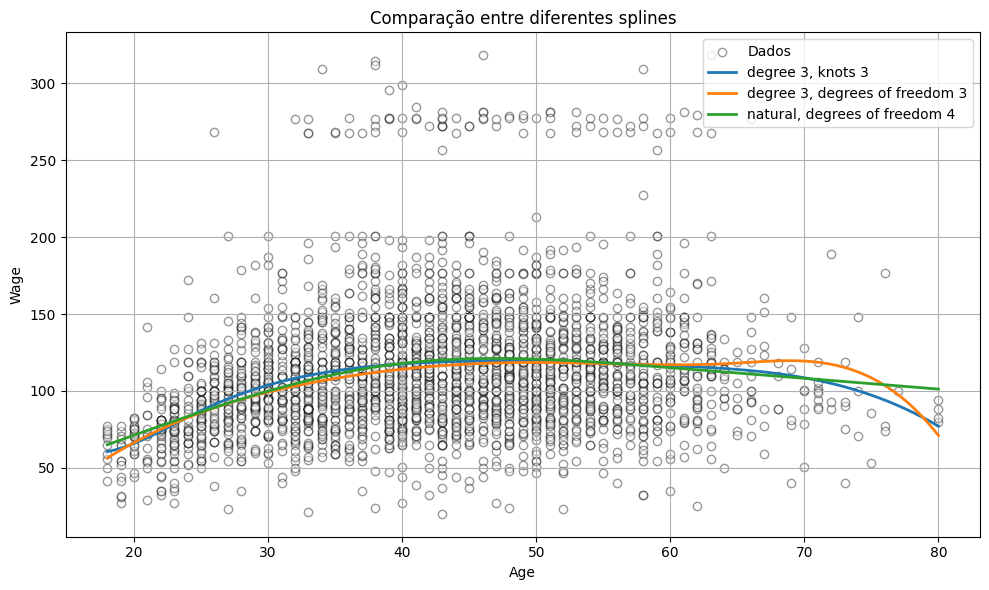

In [133]:
# Compare predictons
preds = [pred5, pred6, pred7]
labels = ['degree 3, knots 3', 'degree 3, degrees of freedom 3', 'natural, degrees of freedom 4']
compare_predictions(X, y, x_grid, preds, labels)

***Comparação com Regressão Polinomial***

Splines de regressão geralmente apresentam resultados superiores à regressão polinomial. Isso ocorre porque, diferentemente dos polinômios, que precisam usar um grau alto para produzir ajustes flexíveis, as splines introduzem flexibilidade aumentando o número de nós, mas mantendo o grau fixo.

Agora vamos ajustar um polinômio de grau 15 e uma spline com 15 graus de liberdade.

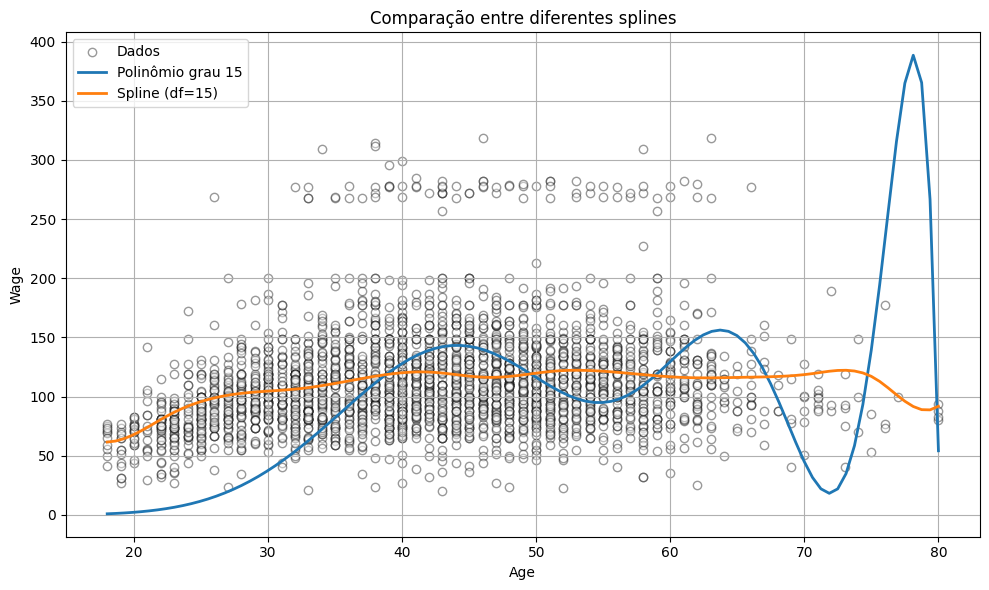

In [134]:
# 1. Regressão polinomial de grau 15
X_poly15 = PolynomialFeatures(15).fit_transform(df[["age"]])
ols_poly_15 = sm.OLS(df["wage"], X_poly15).fit()

# Previsões no grid
x_grid_df = pd.DataFrame({"age": x_grid})
X_poly15_grid = PolynomialFeatures(15).fit_transform(x_grid_df)
pred8 = ols_poly_15.predict(X_poly15_grid)

# 2. Regressão spline com 15 graus de liberdade
spline9 = "bs(x, df=15, degree=3, include_intercept=False)"
pred9 = fit_predict_spline(spline9, df["age"], df["wage"], x_grid)

# 3. Comparar as previsões
preds = [pred8, pred9]
labels = ['Polinômio grau 15', 'Spline (df=15)']
compare_predictions(df["age"], df["wage"], x_grid, preds, labels)

***Comparação entre polinômio de grau alto e spline***

A regressão polinomial de grau 15 tende a se ajustar fortemente aos dados, mas pode oscilar demais nas bordas (problema clássico de overfitting e instabilidade).

Já a spline com 15 graus de liberdade também é muito flexível, mas suas quebras locais em nós garantem **suavidade local** e maior **estabilidade nas extremidades**.

Essa comparação mostra por que splines são preferidas para ajustes flexíveis com melhor controle de comportamento.

### Local Regression (Regressão Local)

Até agora, exploramos os chamados **métodos globais** — técnicas que impõem uma única especificação funcional sobre **todo o domínio** dos dados.  

Exemplos de métodos globais:
- Polinômios de alto grau;
- Splines cúbicas e naturais;
- Modelos paramétricos com termos não lineares fixos.

Mesmo quando permitem flexibilidade, como nas splines, esses métodos ainda constroem **uma função contínua para todo o conjunto de dados**, controlando apenas onde e como ela pode se ajustar.

***O que é Regressão Local?***

A **regressão local** segue uma filosofia diferente:
* Em vez de tentar encontrar **uma única curva que se ajuste a todo o conjunto de dados**, ajustamos **uma regressão diferente para cada ponto** onde queremos prever.
* Essa regressão usa **apenas os dados mais próximos do ponto-alvo**, ponderando as observações de acordo com sua **distância** até esse ponto.
Como funciona a Regressão Local?

A ideia central da **regressão local** é estimar a relação entre $x$ e $y$ **em torno de um ponto de interesse $x_0$**, utilizando apenas observações próximas, com pesos decrescentes conforme a distância de $x_0$.

***Componentes Principais:***

- Um **ponto-alvo** $x_0$ no qual você quer prever $y$;
- Um **kernel de ponderação** $K(\cdot)$ que define os pesos para as observações próximas a $x_0$;
- Um **bandwidth** $h$ que controla a largura da vizinhança (ou seja, quão “local” será o ajuste).


***Vantagens do modelo linear local***

* Resolve o problema de viés nas extremidades que ocorre na regressão local constante;
* Capta melhor mudanças suaves de inclinação (primeira derivada);
* Ainda é não paramétrico — nenhuma forma funcional global é assumida.


***Etapas da Regressão Local Linear***

Para cada ponto $x_0 \in X_{\text{grid}}$:

1. **Calcula os pesos para todas as observações $x_i$** usando um kernel:

$$
w_i = K\left( \frac{x_i - x_0}{h} \right)
$$

1. **Ajusta um modelo linear localmente ponderado**:

$$
y_i \approx \beta_0 + \beta_1 (x_i - x_0)
$$

3. **Minimiza a soma dos erros quadráticos ponderados**:

$$
\sum_i w_i \cdot \left( y_i - \beta_0 - \beta_1 (x_i - x_0) \right)^2
$$

4. **A previsão no ponto $x_0$** é simplesmente:

$$
\hat{y}(x_0) = \hat{\beta}_0
$$

***A inclinação local $\hat{\beta}_1$ não é usada diretamente na previsão, mas melhora o ajuste local e reduz o viés nas bordas.***

   * OBS: Um **kernel** é uma função não-negativa $K(u)$ que:
     - é máxima quando $u = 0$ (isto é, quando $x_i = x_0$);
     - decresce conforme $|x_i - x_0|$ aumenta;
     - satisfaz $\int K(u) \, du = 1$ (ou seja, é uma função de densidade).

Vamos fazer um exemplo simulado.

In [135]:
# Set seed
np.random.seed(1)

# Generate data
X_sim = np.sort(np.random.uniform(0,1,100))
e = np.random.uniform(-.5,.5,100)
y_sim = -4*X_sim**2 + 3*X_sim + e

# Verdadeiro processo gerador dos dados sem ruído
X_grid = np.linspace(0,1,100)
y_grid = -4*X_grid**2 + 3*X_grid

In [136]:
def plot_simulated_data(X, y, X_grid, y_grid):
    """
    Plota os dados simulados e a função verdadeira (sem ruído).
    
    Parâmetros:
    - X: vetor de entrada (amostra) com ruído
    - y: vetor de saída (amostra) com ruído
    - X_grid: vetor contínuo de entrada (para traçar a curva verdadeira)
    - y_grid: vetor contínuo da função verdadeira (sem ruído)
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='w', edgecolor='k', alpha=0.5, label='Dados com ruído')
    plt.plot(X_grid, y_grid, color='crimson', label='Função verdadeira', linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Dados simulados vs. função verdadeira")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plotagem
Vamos visualizar os dados simulados e a curva sem ruído.

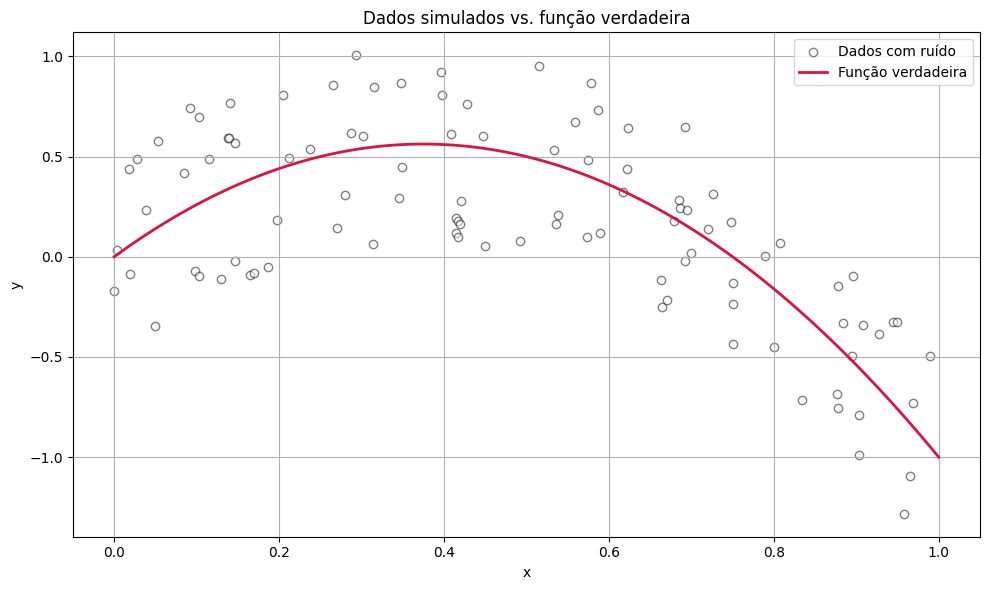

In [137]:
plot_simulated_data(X_sim, y_sim, X_grid, y_grid);

***Ajuste de regressão LL***

A regressão local linear é uma forma de ***regressão não paramétrica*** que ajusta, para cada ponto onde queremos prever, um modelo linear usando apenas dados próximos, com maior peso para os mais próximos.

* Prever o valor de $y$ em cada ponto $x_0$ sem assumir uma forma funcional global para $f(x)$.

In [138]:
# Settings
spec = 'll'
bandwidth = 0.1
kernel = 'gaussian'

* '`ll`' → usamos regressão local linear (poderia ser 'lc' para local constante);
* `bandwidth = 0.1` → controla o tamanho da vizinhança local;
* O kernel padrão é gaussiano, mesmo que não tenha sido explicitado.

In [140]:
# Locally linear regression
local_reg = KernelReg(y_sim, X_sim.reshape(-1,1), 
                      var_type='c', 
                      reg_type=spec, 
                      bw=[bandwidth])

* `y_sim` é o vetor da variável dependente ($y_i$);
* `X_sim` são as observações da variável explicativa ($x_i$), aqui como vetor 2D com .reshape(-1, 1);
* `var_type='c'` indica que estamos usando uma variável contínua (poderia ser 'u' para categórica unordered ou 'o' para ordered);
* `reg_type='ll'` diz que queremos regressão local linear;
* `bw=[bandwidth]` especifica o bandwidth da regressão.

O objeto local_reg agora está pronto para fazer previsões (é uma tupla com valores preditos e erro padrão).

In [141]:
y_hat, y_se = local_reg.fit(X_grid)

In [142]:
# Plotagem semelhante à Figure 7.9a
def plot_local_regression(X_sim, y_sim, X_grid, y_grid, y_hat, title='Local Linear Regression'):
    plt.figure(figsize=(10, 6))
    
    # Dados simulados
    plt.scatter(X_sim, y_sim, color='w', edgecolor='k', alpha=0.6, label='Dados com ruído')
    
    # Verdadeira função geradora
    plt.plot(X_grid, y_grid, color='crimson', label='Função verdadeira', linewidth=2)
    
    # Regressão local linear
    plt.plot(X_grid, y_hat, color='blue', label='Ajuste local linear', linewidth=2)
    
    # Eixos e título
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

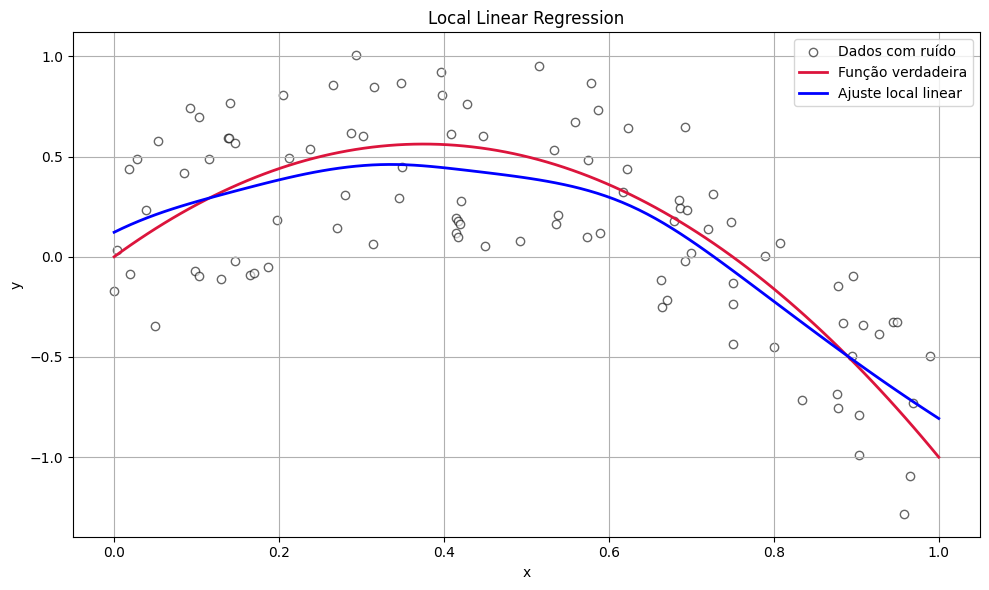

In [143]:
plot_local_regression(X_sim, y_sim, X_grid, y_grid, y_hat)

***Detalhes: Como exatamente a previsão foi gerada?***

A regressão local linear (LL) gera previsões **pontualmente**: ou seja, ela estima $\hat{y}(x_0)$ **para cada ponto $x_0$ separadamente**, usando uma regressão linear ponderada apenas com os vizinhos de $x_0$.

***Passos para prever em um ponto específico $x_0$***

1. **Selecionamos o ponto focal:**  $ x_0 = 0.5 $

2. **Selecionamos observações próximas de $x_0$:**  Ou seja, todos os $x_i$ no conjunto de treino tal que: $ |x_i - x_0| \text{ é pequeno}$

3. **Aplicamos pesos gaussianos:** $ w_i = \exp\left( -\frac{(x_i - x_0)^2}{2 h^2} \right) $
   - Quanto mais distante $x_i$ estiver de $x_0$, **menor o peso**.
   - O parâmetro $h$ é a **largura de banda** (bandwidth).

4. **Executamos uma regressão linear ponderada de $y$ sobre $(1, x)$:**
   
   Resolvemos:
   $$
   \min_{\beta_0, \beta_1} \sum_{i=1}^n w_i \cdot \left(y_i - \beta_0 - \beta_1 (x_i - x_0)\right)^2
   $$

   Ou seja, ajustamos um modelo:
   $$
   y_i \approx \beta_0 + \beta_1(x_i - x_0)
   $$

   - Note que **centralizamos** $x_i$ em torno de $x_0$: isso garante que a previsão em $x_0$ seja simplesmente $\hat{y}(x_0) = \hat{\beta}_0$.



Vamos tentar visualizar isso.

In [144]:
# Get local X and y
x_i = 0.5
close_to_i = (x_i-bandwidth < X_sim) & (X_sim < x_i+bandwidth)
X_tilde = X_sim[close_to_i]
y_tilde = y_sim[close_to_i]

# Get local estimates
local_estimate = KernelReg.fit(local_reg, data_predict=[x_i])
y_i_hat = local_estimate[0]
beta_i_hat = local_estimate[1]
alpha_i_hat = y_i_hat - beta_i_hat*x_i
print('Estimates: alpha=%1.4f, beta=%1.4f' % (alpha_i_hat, beta_i_hat))

Estimates: alpha=0.7006, beta=-0.6141


C:\Users\danie\AppData\Local\Temp\ipykernel_14652\3887452166.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Estimates: alpha=%1.4f, beta=%1.4f' % (alpha_i_hat, beta_i_hat))


Visualização

Agora podemos usar os coeficientes estimados localmente para prever o valor de $y$ em $x_0$.

In [146]:
# Build local predictions
close_to_i_grid = (x_i-bandwidth < X_grid) & (X_grid < x_i+bandwidth)
X_grid_tilde = X_grid[close_to_i_grid].reshape(-1,1)
y_grid_tilde = alpha_i_hat + X_grid_tilde*beta_i_hat

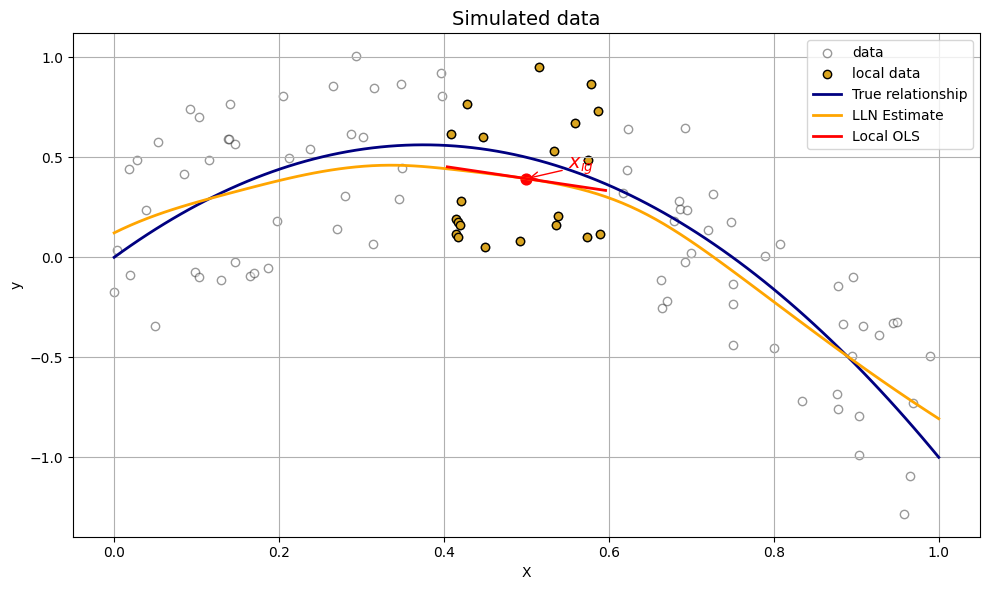

In [147]:
# Estilo dos pontos locais usados
close_to_i = (x_i-bandwidth < X_sim) & (X_sim < x_i+bandwidth)
X_tilde = X_sim[close_to_i]
y_tilde = y_sim[close_to_i]

# Regressão local (já feita previamente):
# local_reg = KernelReg(...)
# y_hat, _ = local_reg.fit(X_grid)

# Regressão local linear centrada em x_i
X_grid_tilde = X_grid[close_to_i_grid].reshape(-1,1)
y_grid_tilde = alpha_i_hat + X_grid_tilde*beta_i_hat

# Plotagem
plt.figure(figsize=(10,6))

# Dados totais com ruído
plt.scatter(X_sim, y_sim, color='w', edgecolor='k', alpha=0.4, label='data')

# Pontos locais usados para x_i
plt.scatter(X_tilde, y_tilde, color='goldenrod', edgecolor='k', label='local data')

# Curva verdadeira
plt.plot(X_grid, y_grid, color='navy', linewidth=2, label='True relationship')

# Estimativa de regressão local linear
plt.plot(X_grid, y_hat, color='orange', linewidth=2, label='LLN Estimate')

# Reta local linear centrada em x_i
plt.plot(X_grid_tilde, y_grid_tilde, color='red', linewidth=2, label='Local OLS')

# Destaque do ponto x_i
plt.scatter([x_i], [y_i_hat], color='red', s=60)
plt.annotate(r'$x_{ig}$', xy=(x_i, y_i_hat), xytext=(x_i+0.05, y_i_hat+0.05),
             color='red', fontsize=14, arrowprops=dict(arrowstyle='->', color='red'))

# Finalização
plt.title('Simulated data', fontsize=14)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ampliando
Podemos ampliar e olhar apenas para a amostra “ próximo a $x_i$ ”.

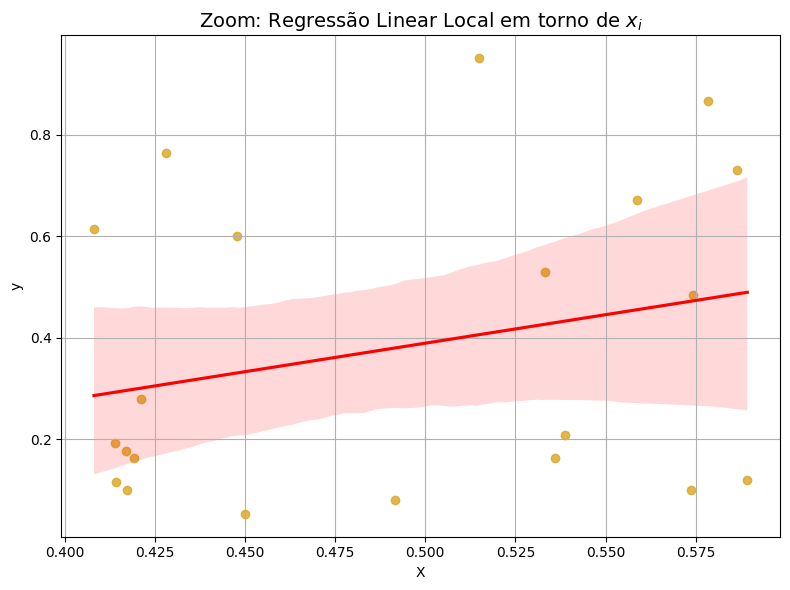

In [148]:
plt.figure(figsize=(8, 6))
sns.regplot(x=X_tilde, y=y_tilde, scatter_kws={'color':'goldenrod'}, line_kws={'color':'red'})
plt.title('Zoom: Regressão Linear Local em torno de $x_i$', fontsize=14)
plt.xlabel('X')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()

Por que a reta é inclinada para cima? Esquecemos os pesos gaussianos!

In [149]:
# Weights
w = norm.pdf((X_sim-x_i)/bandwidth)

# Estimate LWS
mod_wls = sm.WLS(y_sim, sm.add_constant(X_sim), weights=w)
results = mod_wls.fit()

print('Estimates: alpha=%1.4f, beta=%1.4f' % tuple(results.params))

Estimates: alpha=0.7006, beta=-0.6141


In [150]:
def make_figure_7_9d(X, y, weights, model, X_grid, x_i, y_i_hat):
    """
    Reproduz a Figura 7.9d: regressão local linear com pesos gaussianos.
    """
    alpha, beta = model.params
    y_grid = alpha + beta * X_grid

    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(X, y, c=weights, cmap='YlOrRd', edgecolor='k', s=60)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("gaussian weights")

    ax.plot(X_grid, y_grid, color='red', lw=2, label='Local OLS')
    ax.scatter(x_i, y_i_hat, color='red', s=80, zorder=5)
    ax.text(x_i + 0.01, y_i_hat, '$x_i$', color='red', fontsize=14)

    ax.set_title("Local Weighted Least Squares")
    ax.set_xlabel("local X")
    ax.set_ylabel("local y")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


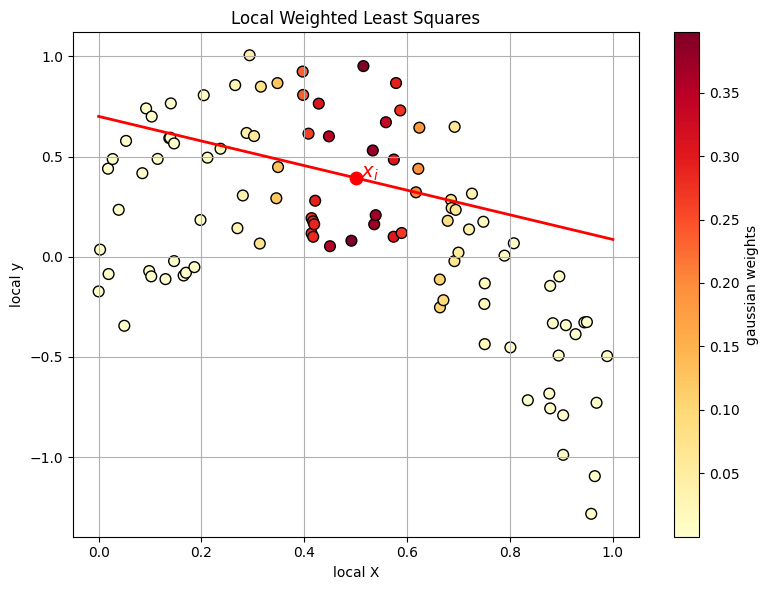

In [104]:
make_figure_7_9d(X_sim, y_sim, w, results, X_grid, x_i, y_i_hat)

### 7. Generalized Additive Models (GAMs - Modelos Aditivos Generalizados)

Os ***Generalized Additive Models*** (GAMs - Modelos Aditivos Generalizados) estendem os modelos lineares tradicionais ao permitir que cada preditor influencie a variável resposta de maneira não linear, mas mantendo a estrutura aditiva.

O GAM mantém a interpretabilidade da regressão linear (efeitos separados de cada variável), mas incorpora a flexibilidade dos métodos não lineares (como splines e regressões locais). 

Ao invés de assumir uma forma funcional rígida (reta, polinômio), GAM aprende a forma da função diretamente dos dados. Cada variável tem seu próprio “modelo”, e o resultado é a soma das contribuições.

É um modelo semiparamétrico:
* Ele não impõe uma forma funcional rígida (como linear, quadrática, etc.) para as variáveis contínuas. Essas funções $f_j(X_j)$ são estimadas a partir dos dados com regularização (penalidade de suavidade).
* Ao mesmo tempo, o modelo mantém a estrutura aditiva, ou seja, $Y$ é explicado como soma de funções univariadas — o que o diferencia dos modelos totalmente não paramétricos.

A forma geral de um GAM é:

$$ E[Y_i \mid X_i] = \alpha + f_1(X_1) + f_2(X_2) + \ldots + f_k(X_k) $$


Cada $f_j(X_j)$ é uma função suave (por exemplo, spline), estimada separadamente para cada preditor $X_j$.

***Relação entre GAMs e os modelos anteriores***

| Modelo anterior             | Formulação                                                                 | Restrição Imposta                                              | GAM como generalização                                   |
|----------------------------|-----------------------------------------------------------------------------|----------------------------------------------------------------|-----------------------------------------------------------|
| **Regressão Linear**       | $$ E[Y \mid X] = \alpha + \beta_1 X_1 + \ldots + \beta_k X_k $$             | Relação estritamente linear entre $Y$ e cada $X_j$            | GAM permite $f_j(X_j)$ não linear                        |
| **Polinômios**             | $$ E[Y \mid X] = \beta_0 + \beta_1 X + \beta_2 X^2 + \ldots $$              | Não linear, mas com forma **global e rígida**                 | GAM usa **splines** mais suaves e flexíveis              |
| **Funções Degrau (Step)**  | $$ E[Y \mid X] = \alpha + \sum_j \gamma_j \cdot \mathbf{1}(X \in I_j) $$    | Mudanças abruptas em intervalos (discretizações)             | GAM representa essas transições suavemente com splines   |
| **Splines Regulares**      | $$ E[Y \mid X] = \alpha + \sum_j \beta_j B_j(X) $$                          | Usa funções base $B_j(X)$ fixas nos nós (knots)               | GAM ajusta suavidade via regularização                   |
| **Regressão Local (Kernel)** | $$ \hat{Y}(x_0) = \sum_i w_i(x_0) Y_i $$                                  | Altamente flexível, mas **não paramétrico**                   | GAM é **semi-paramétrico**, mais interpretável           |


***Exemplo aplicado:***

Considere o modelo com:

* Uma spline natural com 8 graus de liberdade para o ano
* Uma spline natural com 10 graus de liberdade para idade
* Uma função degrau para educação

In [151]:
# Preparar X e y
df['education_'] = LabelEncoder().fit_transform(df["education"])
X = df[['year','age','education_']].to_numpy()
y = df[['wage']].to_numpy()

# Estimar o modelo
linear_gam = LinearGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2))
linear_gam.gridsearch(X, y)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

Plotagem

In [152]:
def plot_gam(model, X=None, feature_names=None):
    """
    Plota os efeitos parciais de cada termo do GAM.
    
    model: modelo treinado do tipo LinearGAM ou LogisticGAM
    X: matriz de dados de entrada (opcional, apenas para uso com feature_names)
    feature_names: lista com nomes das variáveis (opcional)
    """
    n_terms = len(model.terms) - 1  # Ignora o intercepto
    plt.figure(figsize=(4 * n_terms, 4))

    for i in range(n_terms):
        plt.subplot(1, n_terms, i + 1)
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, width=0.95)
        plt.plot(XX[:, i], pdep, color="crimson", label='Efeito parcial')
        plt.plot(XX[:, i], confi[:, 0], color='gray', linestyle='dashed')
        plt.plot(XX[:, i], confi[:, 1], color='gray', linestyle='dashed')
        plt.title(f"Efeito de {feature_names[i] if feature_names else f'X_{i}'}")
        plt.xlabel(feature_names[i] if feature_names else f"X_{i}")
        plt.ylabel("Efeito parcial")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

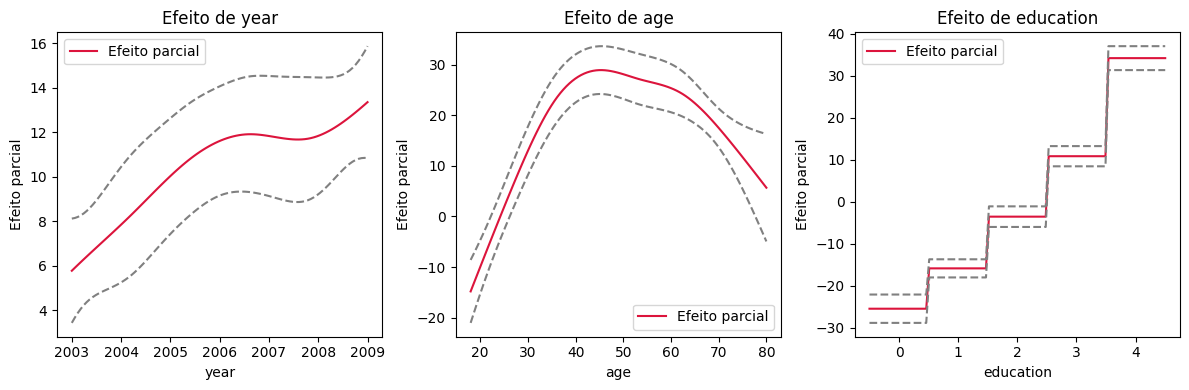

In [153]:
# Plotar os efeitos
plot_gam(linear_gam, X, feature_names=["year", "age", "education"])

***Vantagens e Limitações dos GAMs***

Prós:
* Modela relações não lineares automaticamente
* Cada variável pode ter uma forma funcional diferente
* Estrutura aditiva facilita interpretação
* Permite regular a suavidade de cada componente via graus de liberdade

Contras:
* A estrutura aditiva impede que o modelo capture interações complexas entre variáveis
* Interações precisam ser incluídas manualmente como novos termos


### 7.1. GAMs para Classificação

GAMs também podem ser usados com variáveis binárias, por exemplo, com link logit:

In [154]:
# Variável dependente binária
y_binary = (y > 250)

# GAM com link logítico
logit_gam = LogisticGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2), fit_intercept=True)
logit_gam.gridsearch(X, y_binary)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

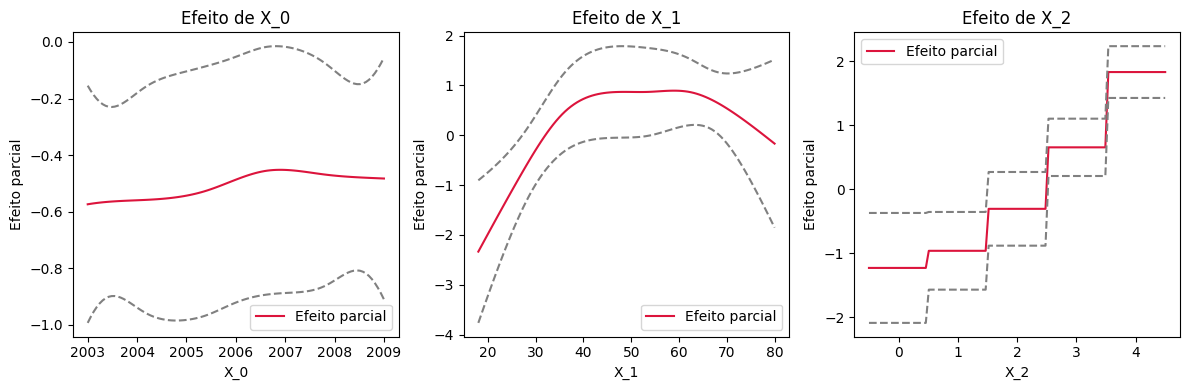

In [155]:
# Visualizar os efeitos
plot_gam(logit_gam)

***Considerações Finais sobre o GAM***

Os GAMs são ferramentas poderosas para explorar relações não lineares entre as variáveis, preservando uma estrutura interpretável. É possível aplicá-los tanto a problemas de regressão (variável de resposta contínua) quanto de classificação (variável de resposta binária/discreta), com opções de *link* apropriadas (como logit).

--- 

Exemplo extra de GAMs com dados do peso dos bebês ao nascer.


In [ ]:
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

# Criar a variável de resultado Y
df['Y'] = df['bweight']

# Criar a variável de tratamento 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodificar a variável de tratamento 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

Para o nosso caso específico, vamos especificar:

$$ Y = \beta_0 + s_1(\text{age}) + f_2(\text{Treatment}) + s_3(\text{medu}) + s_4(\text{fedu}) + s_5(\text{fage}) $$

* s(0) = spline para mage (índice 0 em X)
* f(1) = fator para Treated (índice 1 em X)
* s(2) = spline para meduc (índice 2 em X) / Poderíamos colocar l() para linear
* s(3) = spline para feduc (índice 3 em X)
* s(4) = spline para fage (índice 4 em X)

$s_{i}(⋅)$ ou $f_{i}()$ ou $l(.)$; o modelo "aprende" a forma da relação a partir dos dados, evitando pressupor linearidade.

In [158]:
from pygam import LinearGAM, s, f, l

# Supondo que df seja o DataFrame com os dados
# X contém as variáveis preditoras
X = df[['mage', 'Treated', 'medu', 'fedu', 'fage']].to_numpy()

# Variável resposta (substitua 'y' pelo nome real da coluna)
y = df['Y'].to_numpy()

# Especificar o modelo GAM
gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + s(4))

# Ajustar o modelo aos dados
gam.fit(X, y)

# Exibir o resumo do modelo
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     52.6716
Link Function:                     IdentityLink Log Likelihood:                                -63099.3851
Number of Samples:                         4642 AIC:                                           126306.1134
                                                AICc:                                          126307.3927
                                                GCV:                                            326054.732
                                                Scale:                                         319402.1428
                                                Pseudo R-Squared:                                   0.0573
Feature Function                  Lam

C:\Users\danie\AppData\Local\Temp\ipykernel_14652\1006973329.py:17: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Vejamos o efeito do tratamento considerando a média das covariáveis.

In [159]:
from pygam import LinearGAM
import numpy as np
# Xalcular o efeito parcial de Treated
term_idx = 1  # Índice do termo f(1)
X_grid = np.tile(df[['mage', 'Treated', 'medu', 'fedu', 'fage']].mean().values, (2,1))
X_grid[0, 1] = 0  # não fumante
X_grid[1, 1] = 1  # fumante
partial_dep = gam.partial_dependence(term=term_idx, X=X_grid)
print("Efeito parcial de Treated (0 vs 1):", partial_dep)

Efeito parcial de Treated (0 vs 1): [ 122.24025013 -122.2401848 ]


Efeito parcial de Treated (0 vs 1): [ 122.24025013 -122.2401848 ]

O efeito do tratamento (Treated = 1) em relação ao não tratamento (Treated = 0) é a diferença entre essas duas estimativas:

$$ Efeito_{Treated} = E[Y \mid Treated = 1] - E[Y \mid Treated = 0] $$

Ou seja, $Efeito do fumo= (-122.24025013)−(122.2401848) = −244.48$ gramas.

O ato de fumar durante a gravidez está associado a uma redução média de aproximadamente 244 gramas no peso do bebê ao nascer, controlando para idade e educação dos pais, via modelo aditivo generalizado (GAM).

Código completo para 500 replicações bootstrap

In [160]:
from pygam import LinearGAM, s, f
import numpy as np
import pandas as pd
from tqdm import tqdm

# Função para estimar o efeito do tratamento em uma amostra
def estimate_treatment_effect(df_sample):
    X_sample = df_sample[['mage', 'Treated', 'medu', 'fedu', 'fage']].to_numpy()
    y_sample = df_sample['Y'].to_numpy()
    
    gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + s(4)).fit(X_sample, y_sample)

    # Definir grid para calcular efeito de Treated (0 vs 1), mantendo outras covariáveis constantes
    X_grid = np.zeros((2, 5))
    X_grid[:, 1] = [0, 1]  # Treated: 0 e 1
    
    # Efeito marginal de Treated
    preds = gam.partial_dependence(term=1, X=X_grid)
    effect = preds[1] - preds[0]
    return effect

# Rodar bootstrap
B = 500  # número de repetições
effects = []

np.random.seed(123)  # para reprodutibilidade

for _ in tqdm(range(B), desc="Rodando bootstrap"):
    df_sample = df.sample(frac=1, replace=True)
    try:
        effect = estimate_treatment_effect(df_sample)
        effects.append(effect)
    except Exception:
        continue  # pular se houver erro de convergência

# Resultados
effects = np.array(effects)
point_estimate = np.mean(effects)
std_error = np.std(effects, ddof=1)

# Intervalo de confiança (95%)
ci_lower = np.percentile(effects, 2.5)
ci_upper = np.percentile(effects, 97.5)

print(f"Efeito médio do tratamento (bootstrap): {point_estimate:.2f}")
print(f"Erro padrão bootstrap: {std_error:.2f}")
print(f"IC 95% (percentil): [{ci_lower:.2f}, {ci_upper:.2f}]")

Rodando bootstrap: 100%|██████████| 500/500 [00:52<00:00,  9.59it/s]

Efeito médio do tratamento (bootstrap): -243.88
Erro padrão bootstrap: 21.70
IC 95% (percentil): [-287.16, -203.40]


***Mulheres que fumam durante a gravidez têm bebês que nascem com, em média, 244.48 gramas a menos do que bebês de mulheres que não fumam***, controlando de forma não linear para idade e escolaridade dos pais (via GAM).

Esse efeito é estatisticamente significativo:
* O intervalo de confiança não inclui zero, o que reforça a conclusão de que o efeito é real (estatisticamente distinto de zero).
* A incerteza (margem de erro) é relativamente pequena: cerca de ±21.70g.
* O efeito bootstrap não deve ser considerado. Entretanto, o calculo do erro padrão bootstrap é uma boa prática para validar a robustez do modelo (veremos isso na próxima aula).